In [1]:
import os
import glob
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2

import pydicom

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights

In [2]:
DATASET_NAME = 'rsna-cnn-training'
KAGGLE_DIR = '/media02/tdhoang01/data'

ROOT_DIR = os.path.join(KAGGLE_DIR, DATASET_NAME)
DATA_DIR = os.path.join(ROOT_DIR, DATASET_NAME)
DICOM_DIR = DATA_DIR

CSV_PATH = os.path.join(DATA_DIR, 'training_20_scan_subset.csv')
SLICE_LABEL_PATH = os.path.join(ROOT_DIR, "sorted_training_dataset_with_labels.csv")

# Load patient scan labels
patient_scan_labels = pd.read_csv(CSV_PATH)
patient_slice_labels = pd.read_csv(SLICE_LABEL_PATH)

In [3]:
MAX_SLICES = 60

HEIGHT = 224
WIDTH = 224

BATCH_PATIENTS = 8

VAL_SIZE = 0.15
TEST_SIZE = 0.15

TARGET_COLUMNS = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

In [4]:
patient_scan_labels.head(1)

,patient_id,study_instance_uid,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_0002cd41,ID_66929e09d4,0,0,0,0,0,0


In [5]:
patient_slice_labels.head(1)

,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,patient_id,study_instance_uid,series_instance_uid,image_position,samples_per_pixel,pixel_spacing,pixel_representation,window_center,window_width,rescale_intercept,rescale_slope,ID
0,ID_45785016b.dcm,0,0,0,0,0,0,ID_0002cd41,ID_66929e09d4,ID_e22a5534e6,"[-125.000, -122.596, 35.968]",1,"[0.488281, 0.488281]",1,30,80,-1024.0,1.0,45785016b


In [6]:
class DatasetGenerator(Dataset):
    """
    A custom PyTorch Dataset for processing and preparing medical imaging DICOM data.

    This class handles multi-slice medical scans (e.g., CT or MRI), processing DICOM files,
    applying image preprocessing techniques, and preparing labels for machine learning tasks.

    Features:
    - DICOM file handling and organization
    - Image preprocessing (resizing, windowing)
    - Multi-slice support with padding/truncation
    - Label processing for patient-level and slice-level data
    - Basic data augmentation
    - Efficient data loading
    - Flexible target selection for classification

    Args:
        dicom_dir (str): Directory containing the DICOM files.
        patient_scan_labels (pd.DataFrame): DataFrame with patient-level scan labels.
        patient_slice_labels (pd.DataFrame): DataFrame with slice-level labels.
        max_slices (int): Maximum number of slices to consider per scan.
        height (int): Desired height of the processed images.
        width (int): Desired width of the processed images.
        target_columns (list): List of column names to use as classification targets.

    Attributes:
        dicom_dir (str): Directory containing the DICOM files.
        patient_scan_labels (pd.DataFrame): DataFrame with patient-level scan labels.
        patient_slice_labels (pd.DataFrame): DataFrame with slice-level labels.
        max_slices (int): Maximum number of slices per scan.
        channels (int): Number of channels in the processed images (default: 3).
        height (int): Height of the processed images.
        width (int): Width of the processed images.
        target_columns (list): List of target column names for classification.
        dicom_paths (list): List of tuples containing DICOM file paths and corresponding rows.
        transform (torchvision.transforms.Compose): Image transformation pipeline.

    Example:
        >>> dataset = DatasetGenerator(dicom_dir='path/to/dicoms',
        ...                            patient_scan_labels=scan_df,
        ...                            patient_slice_labels=slice_df,
        ...                            max_slices=100,
        ...                            height=224,
        ...                            width=224,
        ...                            target_columns=['label1', 'label2'])
        >>> image_tensor, label_tensor = dataset[0]
    """
    def __init__(self, dicom_dir, patient_scan_labels, patient_slice_labels, max_slices, height, width, target_columns):
        self.dicom_dir = dicom_dir
        self.patient_scan_labels = patient_scan_labels
        self.patient_slice_labels = patient_slice_labels
        self.max_slices = max_slices
        self.channels = 3
        self.height = height
        self.width = width
        self.target_columns = target_columns
        self.dicom_paths = self._get_dicom_paths()
        self.transform = transforms.Compose([
            transforms.Resize((self.height, self.width))
        ])

    def _get_dicom_paths(self):
        dicom_paths = []
        for _, row in self.patient_scan_labels.iterrows():
            patient_id = row['patient_id'].replace("ID_", "")
            study_instance_uid = row['study_instance_uid'].replace("ID_", "")
            dicom_dir_path = os.path.join(self.dicom_dir, f"{patient_id}_{study_instance_uid}")
            
            if os.path.exists(dicom_dir_path):
                dicom_files = glob.glob(os.path.join(dicom_dir_path, "*.dcm"))
                if dicom_files:
                    dicom_paths.append((dicom_files, row))
                else:
                    print(f"No DICOM files found in {dicom_dir_path}")
            else:
                print(f"Directory {dicom_dir_path} does not exist.")
        return dicom_paths

    def __len__(self):
        return len(self.dicom_paths)

    def _pad_images(self, images):
        num_slices = images.shape[0]
        if num_slices < self.max_slices:
            padding = torch.zeros((self.max_slices - num_slices, self.channels, self.height, self.width))
            images = torch.cat((images, padding), dim=0)
        return images
    
    def _pad_labels(self, labels_tensor):
        if len(labels_tensor) < self.max_slices:
            padding_labels = torch.zeros(self.max_slices - len(labels_tensor))
            labels_tensor = torch.cat((labels_tensor, padding_labels))
        return labels_tensor

    def correct_dcm(self, dcm):
        x = dcm.pixel_array + 1000
        px_mode = 4096
        x[x >= px_mode] -= px_mode
        dcm.PixelData = x.tobytes()
        dcm.RescaleIntercept = -1000

    def window_image(self, dcm, window_center, window_width):    
        if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
            self.correct_dcm(dcm)
        
        img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
        img = cv2.resize(img, (self.height, self.width), interpolation=cv2.INTER_LINEAR)
       
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        
        return img

    def bsb_window(self, dcm):
        brain_img = self.window_image(dcm, 40, 80)
        subdural_img = self.window_image(dcm, 80, 200)
        soft_img = self.window_image(dcm, 40, 380)
        
        brain_img = (brain_img - 0) / 80
        subdural_img = (subdural_img - (-20)) / 200
        soft_img = (soft_img - (-150)) / 380
        
        bsb_img = np.stack([brain_img, subdural_img, soft_img], axis=0)
        print
        return bsb_img.astype(np.float16)

    def preprocess_slice(self, slice):
        # Check if type of slice is DICOM or an empty numpy array
        if isinstance(slice, np.ndarray):
            # Resize the slice to the desired height and width
            slice_resized = resize(slice, (self.height, self.width), anti_aliasing=True)
            multichannel_slice = np.stack([slice_resized] * 3, axis=0)
            return multichannel_slice.astype(np.float16)
        else:
            bsb_img = self.bsb_window(slice)  # Get the BSB windowed image
            return bsb_img.astype(np.float16)

    def __getitem__(self, idx):
        dicom_files, row = self.dicom_paths[idx]
        images = []
        labels = []

        for dicom_file in dicom_files:
            dicom = pydicom.dcmread(dicom_file)
            img = self.preprocess_slice(dicom)  # Use preprocess_slice instead of converting to 3 channels
            
            img_tensor = torch.from_numpy(img).float()
            images.append(img_tensor)

            file_key = os.path.basename(dicom_file)
            label_row = self.patient_slice_labels[self.patient_slice_labels['filename'] == file_key]
            label = 1.0 if not label_row.empty and np.any(label_row[self.target_columns].values == 1) else 0.0
            labels.append(label)

        images_tensor = torch.stack(images)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)        
            
        # Padding with 0
        images_tensor = self._pad_images(images_tensor)
        labels_tensor = self._pad_labels(labels_tensor)

        return images_tensor, labels_tensor

In [7]:
class DataloaderManager:
    """
    A class to manage DataLoader instances for training, validation, and testing splits of a dataset. 
    It includes methods to create the splits, ensure balanced label distribution, and visualize label counts.

    Attributes:
    ----------
    dataset : Dataset
        The full dataset to be split into training, validation, and testing sets.
    batch_size : int, optional
        The number of samples in each batch (default is 8).
    val_size : float, optional
        The proportion of the dataset to use for validation (default is 0.15).
    test_size : float, optional
        The proportion of the dataset to use for testing (default is 0.15).
    num_workers : int, optional
        The number of subprocesses to use for data loading (default is 4).
    train_loader : DataLoader
        The DataLoader for the training set.
    validate_loader : DataLoader
        The DataLoader for the validation set.
    test_loader : DataLoader
        The DataLoader for the testing set.

    Methods:
    --------
    print_dataset_length():
        Prints the total length of the dataset.
    
    print_lengths():
        Prints the lengths of the training, validation, and testing datasets.
    
    _create_loaders():
        Internal method that splits the dataset into training, validation, and testing sets, and 
        ensures each split contains at least one instance of label 1. DataLoaders are created for each split.
    
    visualize_label_distribution():
        Visualizes the distribution of labels (0 and 1) for the training, validation, and testing datasets.
    """
    def __init__(self, dataset, batch_size, val_size, test_size, num_workers=4):
        self.dataset = dataset
        self.batch_size = batch_size
        self.val_size = val_size
        self.test_size = test_size
        self.num_workers = num_workers
        self.train_loader = None
        self.validate_loader = None
        self.test_loader = None
        self._create_loaders()

    def print_dataset_length(self):
        print(f"Length of dataset: {len(self.dataset)}")

    def print_lengths(self):
        print(f"Length of training dataset: {len(self.train_loader.dataset)}")
        print(f"Length of validation dataset: {len(self.validate_loader.dataset)}")
        print(f"Length of testing dataset: {len(self.test_loader.dataset)}")
    
    def _create_loaders(self):
        dataset_length = len(self.dataset)
        print(f"Dataset length: {dataset_length}")

        # Create masks for indices with and without label 1
        label_mask = np.array([1 in sample[1].tolist() for sample in self.dataset])
        indices_with_one = np.where(label_mask)[0]
        indices_without_one = np.where(~label_mask)[0]

        print(f"Total indices with one: {len(indices_with_one)}")

        # Calculate split sizes
        val_size = int(dataset_length * self.val_size)
        test_size = int(dataset_length * self.test_size)

        # Shuffle and split indices
        np.random.shuffle(indices_with_one)
        np.random.shuffle(indices_without_one)

        val_one_count = int(len(indices_with_one) * self.val_size)
        test_one_count = int(len(indices_with_one) * self.test_size)

        val_indices = np.concatenate((
            indices_with_one[:val_one_count],
            indices_without_one[:val_size - val_one_count]
        ))

        test_indices = np.concatenate((
            indices_with_one[val_one_count:val_one_count + test_one_count],
            indices_without_one[val_size - val_one_count:val_size - val_one_count + test_size - test_one_count]
        ))

        train_indices = np.concatenate((
            indices_with_one[val_one_count + test_one_count:],
            indices_without_one[val_size - val_one_count + test_size - test_one_count:]
        ))

        # Create datasets from selected indices using Subset
        train_dataset = Subset(self.dataset, train_indices)
        val_dataset = Subset(self.dataset, val_indices)
        test_dataset = Subset(self.dataset, test_indices)

        # Create DataLoaders for each set
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
        self.validate_loader = DataLoader(val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def visualize_label_distribution(self):
        for loader_name, loader in zip(['Training', 'Validation', 'Testing'], 
                                        [self.train_loader, self.validate_loader, self.test_loader]):
            all_labels = []
            for _, labels in loader:
                all_labels.extend(labels.view(-1).numpy().tolist())

            label_counts = Counter(all_labels)
            counts = [label_counts.get(0, 0), label_counts.get(1, 0)]
            labels = [0, 1]

            plt.figure(figsize=(10, 6))
            bars = plt.bar(labels, counts, color='blue')
            plt.xlabel('Labels')
            plt.ylabel('Counts')
            plt.title(f'Label Distribution - {loader_name} Set')
            plt.xticks(labels)

            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

In [8]:
dataset = DatasetGenerator(
    DICOM_DIR,
    patient_scan_labels=patient_scan_labels,
    patient_slice_labels=patient_slice_labels,
    max_slices=MAX_SLICES,
    height=HEIGHT,
    width=WIDTH,
    target_columns=TARGET_COLUMNS
)

In [9]:
images, labels = dataset[0]

print(images.shape, labels.shape)

torch.Size([60, 3, 224, 224]) torch.Size([60])


In [10]:
dataloader_manager = DataloaderManager(dataset, batch_size=BATCH_PATIENTS, val_size=VAL_SIZE, test_size=TEST_SIZE)

# Accessing the loaders
train_loader = dataloader_manager.train_loader
validate_loader = dataloader_manager.validate_loader
test_loader = dataloader_manager.test_loader

Dataset length: 20
Total indices with one: 10


In [11]:
dataloader_manager.print_lengths()

Length of training dataset: 14
Length of validation dataset: 3
Length of testing dataset: 3


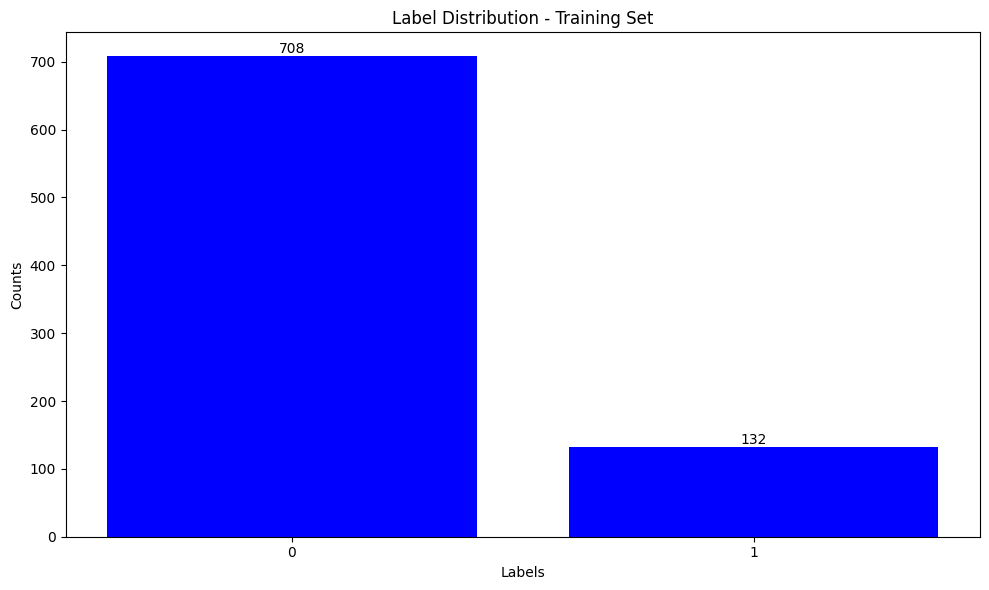

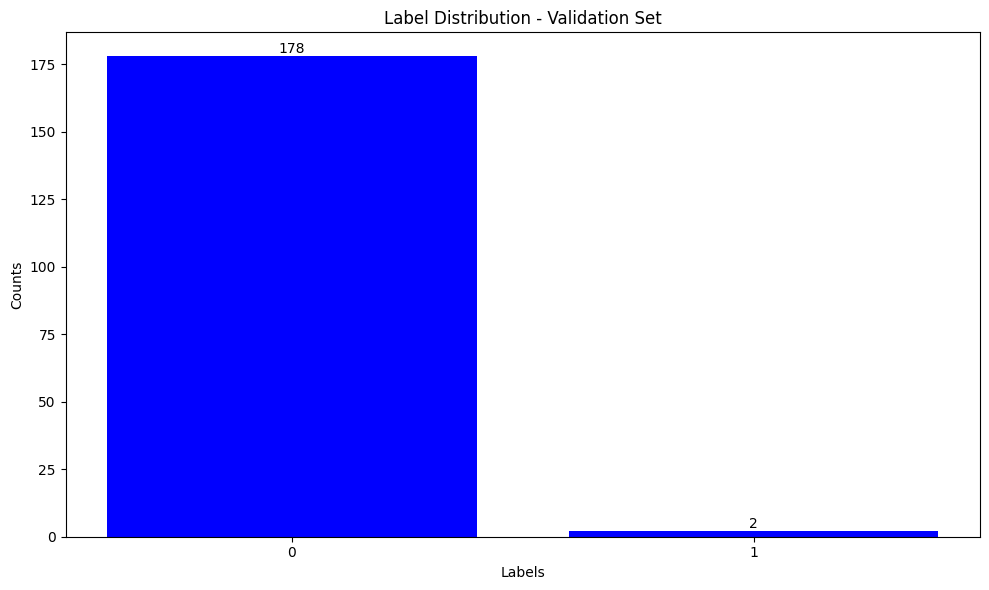

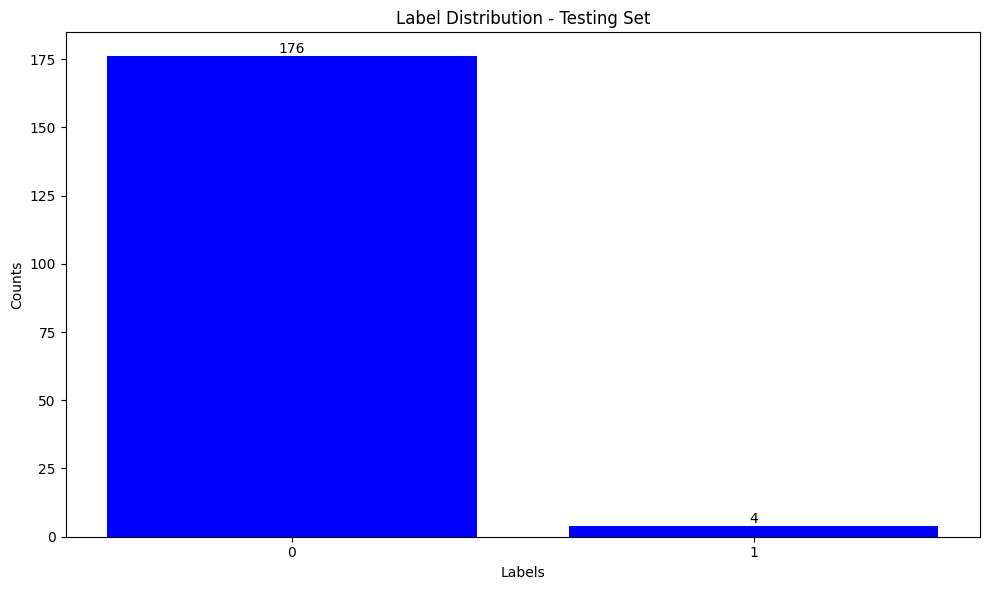

In [12]:
dataloader_manager.visualize_label_distribution()

In [13]:
def plot_image_grid(dataloader, grid_rows=10, max_slices=MAX_SLICES):
    """
    Plot a grid of images from the given DataLoader.
    
    Args:
    dataloader (DataLoader): DataLoader containing batches of images and labels.
    grid_rows (int): Number of rows in the grid
    max_slices (int): Maximum number of slices to plot
    """
    # Get a first value in batch from the DataLoader
    for batch_images, batch_labels in dataloader:
        image_tensor = batch_images[0]
        label_tensor = batch_labels[0]
        break

    num_slices = min(image_tensor.shape[0], max_slices)  # Ensure we don't exceed the number of slices
    grid_cols = int(max_slices / grid_rows)  # Calculate number of columns
    
    # Calculate the figure size based on the image dimensions
    img_size = HEIGHT # or WIDTH
    dpi = plt.rcParams['figure.dpi']  # Get the default DPI
    figsize = (grid_cols * img_size / dpi, grid_rows * img_size / dpi)
    
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    
    # Loop through the number of slices and plot each image
    for i in range(num_slices):
        axes[i].imshow(image_tensor[i].permute(1, 2, 0).cpu().numpy())  # Convert to (height, width, channels) for plotting
        axes[i].set_title(f"Label: {label_tensor[i].item()}")
        axes[i].axis('off')  # Turn off axis for all subplots
    
    # Turn off any remaining empty subplots
    for i in range(num_slices, grid_rows * grid_cols):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [14]:
# plot_image_grid(test_loader)

In [15]:
# 2. Model Definition
class ResNet18(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.dropout = nn.Dropout(p=0.3)  # Add dropout layer

    def forward(self, x):
        batch_patients, num_slices, channels, height, width = x.size()
        x = x.view(-1, channels, height, width)
        x = self.resnet(x)
        return self.dropout(x)  # Apply dropout before returning

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/tdhoang01/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [16]:
# 3. Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

# mode: Monitors 'min' or 'max' changes in metrics.
# factor: The multiplicative factor for reducing the learning rate. 
##  If the current learning rate is 0.01 and factor=0.5, the new learning rate will be 0.01 * 0.5 = 0.005
# patience: Number of epochs to wait for improvement before reducing the learning rate.

In [17]:
def train(model, train_loader, criterion, optimizer, scheduler, num_epochs, device):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)

        # Forward pass
        optimizer.zero_grad()
        output = model(image).squeeze()
        label = label.reshape(-1)

        loss = criterion(output, label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

        # Calculate accuracy
        predicted_label = (output > 0.5).float()
        total += label.size(0)
        correct += (predicted_label == label).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}%')

    scheduler.step(epoch_loss)

In [18]:
def validate(model, validate_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(validate_loader):
            image, label = image.to(device), label.to(device)
            
            # Forward pass
            output = model(image).squeeze()
            label = label.reshape(-1)
            
            loss = criterion(output, label)
            running_loss += loss.item()
            
            # Calculate accuracy
            predicted_label = (output > 0.5).float()
            total += label.size(0)
            correct += (predicted_label == label).sum().item()
    
    # Calculate average loss and accuracy for validation
    val_loss = running_loss / len(validate_loader)
    accuracy = 100 * correct / total
    
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}%')

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [20]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [21]:
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_scores = []

    with torch.no_grad():
        for image, label in test_loader:
            image, label = image.to(device), label.to(device)
            
            output = model(image).squeeze()
            label = label.reshape(-1)
            
            predicted_label = (output > 0.5).float()
            total += label.size(0)
            correct += (predicted_label == label).sum().item()
            
            # Collecting true labels and scores for ROC and confusion matrix
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted_label.cpu().numpy())
            all_scores.extend(output.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.4f}%')
    
    # Plot ROC Curve
    plot_roc_curve(np.array(all_labels), np.array(all_scores))
    
    # Plot Confusion Matrix
    plot_confusion_matrix(np.array(all_labels), np.array(all_predictions))

In [22]:
num_epochs = 10

In [23]:
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, scheduler, num_epochs, device)
    validate(model, validate_loader, criterion, device)

Epoch 1: Loss: 1.2375, Accuracy: 51.3095%
Validation Loss: 0.1570, Validation Accuracy: 98.8889%
Epoch 2: Loss: 0.6332, Accuracy: 80.2381%
Validation Loss: 0.0864, Validation Accuracy: 98.8889%
Epoch 3: Loss: 0.4404, Accuracy: 82.2619%
Validation Loss: 0.0874, Validation Accuracy: 98.8889%
Epoch 4: Loss: 0.3594, Accuracy: 86.1905%
Validation Loss: 0.1137, Validation Accuracy: 98.8889%
Epoch 5: Loss: 0.3413, Accuracy: 89.2857%
Validation Loss: 0.1490, Validation Accuracy: 98.8889%
Epoch 6: Loss: 0.2843, Accuracy: 90.9524%
Validation Loss: 0.2722, Validation Accuracy: 98.8889%
Epoch 7: Loss: 0.2828, Accuracy: 93.0952%
Validation Loss: 0.2079, Validation Accuracy: 98.8889%
Epoch 8: Loss: 0.2562, Accuracy: 94.1667%
Validation Loss: 0.1106, Validation Accuracy: 98.8889%
Epoch 9: Loss: 0.2413, Accuracy: 94.8810%
Validation Loss: 0.0889, Validation Accuracy: 98.8889%
Epoch 10: Loss: 0.2322, Accuracy: 94.5238%
Validation Loss: 0.0797, Validation Accuracy: 98.8889%


Test Accuracy: 97.7778%


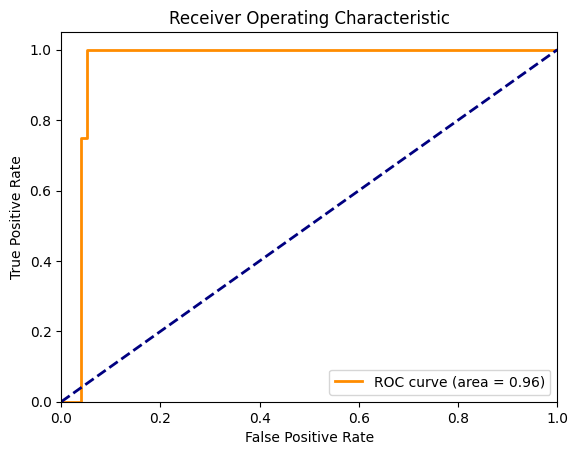

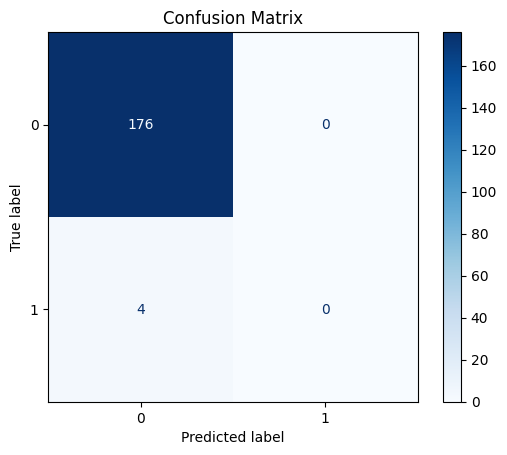

In [24]:
evaluate(model, test_loader, device)